- Retraining last 3 layers
- Adam optimizer with initial lr=0.001
- Decrease lr by a factor of 0.8 if there is no improvement in val_loss for 5 epochs in a row
- Batch size of 64
- Early stopping with 100 epochs maximum
    - stop training if val_loss does not decrease(delta=5.0) for 10 epochs in a row 


In [27]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import math
import matplotlib.pyplot as plt
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'
import os, random
from PIL import Image
import seaborn as sns
sns.set_style("darkgrid")
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Dropout

from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

from tqdm import tqdm_notebook
from keras_tqdm import TQDMNotebookCallback

## sample images

<IPython.core.display.Javascript object>


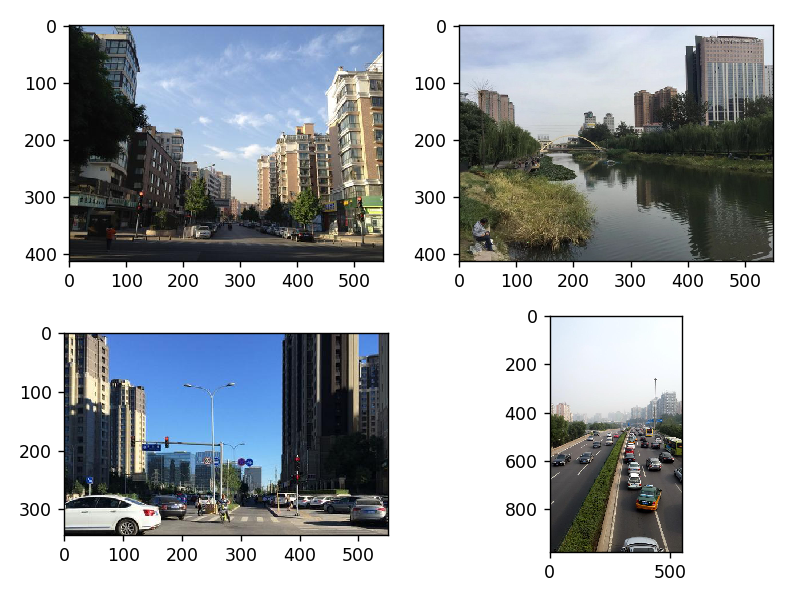

In [2]:
image_directory='../images' #the directory containing images

#randomly displaying some images from the image directory
n=4
#plt.figure(figsize=(10,8))
plt.figure()
for i in range(n):
    random_file = image_directory + "/"+ random.choice(os.listdir(image_directory))
    img = Image.open(random_file)
    plt.subplot(math.ceil(n/2),2,i+1)
    plt.imshow(img)
plt.tight_layout()
plt.show()

In [3]:
if not os.path.isfile('info.csv'):
    csv=open('info.csv', 'w')
    txt=open('info.txt', 'r')
    csv.write("Image Name,PM Value\n")
    for item in txt.readlines():
        item=str(item).strip()
        item=item.split(' ')
        csv.write("{},{}\n".format(item[0], item[1]))
    csv.close()
    txt.close()

pm = pd.read_csv('info.csv') #csv file containing informatin about images
# print 5 samples
#pm.sample(5)
pm['PM Value'].describe()

count    1460.000000
mean     79.273151  
std      87.962335  
min      2.000000   
25%      14.000000  
50%      46.000000  
75%      116.000000 
max      634.000000 
Name: PM Value, dtype: float64

## Histogram of PM values

<IPython.core.display.Javascript object>


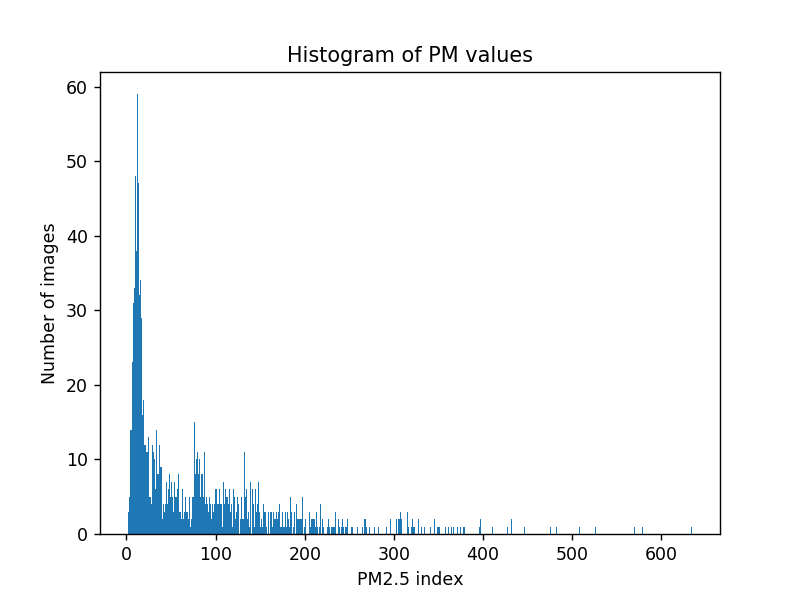

In [4]:
pm.hist(column=['PM Value'], bins=int(pm['PM Value'].max()), grid=False)
plt.xlabel('PM2.5 index')
plt.ylabel('Number of images')
plt.title('Histogram of PM values')

## Dataset Creation

In [5]:
def create_dataset(image_info_file='info.txt', save_path='../data.npz'):
    image_rows=224
    image_cols=224
    image_channels=3
    output_labels=1
    ##################################################

    if not os.path.isfile(save_path):
        # if dataset doesn't exist create it    
        file = open(image_info_file, "r")
        X_data=[]
        Y_data=[]
        Z_data=[]

        for item in file.readlines():
            item=str(item).strip()
            item=item.split(' ')

            #Load the image file
            image_file="../{}".format(item[0])
            img = image.load_img(image_file, target_size=(image_rows, image_cols, image_channels))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            X_data.append(x)
            Y_data.append(item[1])
            Z_data.append(item[0])

        X=np.array(X_data)
        Y=np.array(Y_data)
        Z=np.array(Z_data)
        
        number_of_images=len(X)

        #reshaping and normalizing the data
        X = X.reshape(number_of_images,image_rows,image_cols,image_channels)
        #X /= 255 

        Y = Y.reshape(number_of_images, output_labels)
        Z = Z.reshape(number_of_images, output_labels)
        #shuffling the data
        X, Y, Z = shuffle(X, Y, Z, random_state=9)


        #saving the data
        np.savez(save_path, x=X, y=Y, z=Z)

        print('Data successfully saved to file {}'.format(save_path))

    else:
        print('The file {} already exists'.format(save_path))   
    

In [7]:
#create_dataset()

### Prepare input data and divide into k-parts

This function divides the original data into k parts each contiaining 2 parts (80% and 20% of images). 

Out of K parts,each time k-1 part of data can be used for training and the remaining one part can be used for testing.

In [8]:
def prepare_kfold(filename, k, width, height, depth, num_classes):
    #create_dataset()
    
    if not os.path.isfile('../data_splitted.npz'):
        # if dataset doesn't exist create it 
        folds=k
        ###########################
        data=np.load("../{}".format(filename))
        X=data['x']
        Y=data['y']
        Z=data['z']
        ###########################
        X=np.array(X)
        Y=np.array(Y)
        Z=np.array(Z)
        
        X_train=[]
        X_test=[]
        Y_train=[]
        Y_test=[]
        
        Z_train=[]
        Z_test=[]

        data_size=len(X)
        test_size=int(data_size/folds)
        training_size=data_size-test_size


        for i in range(folds):
            lower_range=int(i*test_size)
            upper_range=int((i+1)*test_size-1)

            splitted_X=np.split(X, [lower_range, upper_range+1])
            splitted_Y=np.split(Y, [lower_range, upper_range+1])
            splitted_Z=np.split(Z, [lower_range, upper_range+1])

            train_X = np.append(splitted_X[0], splitted_X[2])
            test_X = splitted_X[1]

            train_Y = np.append(splitted_Y[0], splitted_Y[2])
            test_Y = splitted_Y[1]
            
            train_Z = np.append(splitted_Z[0], splitted_Z[2])
            test_Z = splitted_Z[1]
            

            X_train.append(train_X)
            X_test.append(test_X)

            Y_train.append(train_Y)
            Y_test.append(test_Y)
            
            Z_train.append(train_Z)
            Z_test.append(test_Z)

            
        Xtrain=np.array(X_train) 
        Xtest=np.array(X_test) 
        Ytrain=np.array(Y_train) 
        Ytest=np.array(Y_test)
        Ztrain=np.array(Z_train) 
        Ztest=np.array(Z_test)

        Xtrain=Xtrain.reshape(folds, training_size, width, height, depth) 
        Xtest=Xtest.reshape(folds, test_size, width, height, depth) 
        Ytrain=Ytrain.reshape(folds, training_size, num_classes) 
        Ytest=Ytest.reshape(folds, test_size, num_classes)
        Ztrain=Ztrain.reshape(folds, training_size, num_classes) 
        Ztest=Ztest.reshape(folds, test_size, num_classes)



        #saving the data
        np.savez('../data_splitted.npz', x_train=Xtrain, x_test=Xtest, y_train=Ytrain, y_test=Ytest, z_train=Ztrain, z_test=Ztest)

        print('Data successfully saved to file "splitted_data.npz"')

    else:
        print('The file data_splitted.npz exists') 
    


## Define the CNN Model

In [2]:
def cnn_model():
    #Load VGG net
    vgg16 = VGG16(weights='imagenet')

    #change the outptu to one neuron
    fc2 = vgg16.get_layer('fc2').output
    fc3 = Dense(1, activation='linear', name='fc3')(fc2)

    #creating the modified CNN model
    model = Model(inputs=vgg16.input, outputs=fc3)
    
    #Freeze all the layers except the last 3 fully connected layers
    for layer in model.layers:
        if layer.name in ['fc1','fc2','fc3']:
            continue
        layer.trainable = False
    
    
    #use adam optimizer with a very small learning rate
    # using mean squared error for regression
    model.compile(loss='mean_squared_error', optimizer=adam(lr=0.001))
    
    return model

## define the training strategy

In [3]:
def train_cnn(k):
    model=cnn_model()
    filepath="models/vgg_model{}.hdf5".format(k)
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    reduce_on_plateau=ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=0, mode='min', epsilon=0.0001, cooldown=0, min_lr=0)
    early_stopping=EarlyStopping(monitor='val_loss', min_delta=5.0, patience=10, verbose=0, mode='auto')
    #tqdm_notebook=TQDMNotebookCallback(leave_inner=True, leave_outer=True)
    tqdm_notebook=TQDMNotebookCallback()
    callbacks_list = [checkpoint, reduce_on_plateau, early_stopping, tqdm_notebook]
    
    xtrain, xval, ytrain, yval = train_test_split(X_train[k-1], Y_train[k-1], test_size=0.125)
    xtr = np.concatenate((xtrain, xtrain[:,:,::-1,:]), axis=0)
    ytr = np.concatenate((ytrain,ytrain), axis=0)
    train_history = model.fit(xtr, ytr, batch_size=64, validation_data=(xval, yval),epochs=100, callbacks=callbacks_list, verbose=1)

    train_losses = np.sqrt(np.array(train_history.history['loss']))
    val_losses = np.sqrt(np.array(train_history.history['val_loss']))
    x_tick=[i+1 for i in range(len(train_losses))]
    plt.figure()
    plt.plot(x_tick,train_losses, label='training', marker='o', linestyle='solid')
    plt.plot(x_tick,val_losses, label='validation', marker='o', linestyle='solid')
    plt.legend(loc='upper right')
    plt.ylabel('Root Mean Square Error(RMSE)')
    plt.xlabel('# Epochs')
    plt.title('Loss')
    plt.grid()
    plt.show()    
    del model

## Evaluation of the model

In [4]:
def evaluate_model(k):
    #load the model
    model = load_model("models/vgg_model{}.hdf5".format(k))
    
    score = model.evaluate(X_test[k-1], Y_test[k-1], batch_size=64)
    rmse = np.sqrt(score)
    print('RMSE for Test data = {}'.format(rmse))
    
    
    ground_truth = np.array(Y_test[k-1])
    x=ground_truth
    x=x.astype(np.float32)
    x=np.reshape(x, len(x))
    
    prediction = model.predict(X_test[k-1])
    y=prediction
    y=np.reshape(y, len(y))
    
    z=Z_test[k-1]
    z=np.reshape(z, len(z))
    
    #saving the data
    np.savez('eval/eval_data{}.npz'.format(k), x=x, y=y, z=z, rms=rmse)
    plt.figure()
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, y, '.', label="PM values")
    plt.plot(x, m*x + b, '-', label="line of best fit")
    plt.legend(loc='upper left')
    plt.ylabel('Prediction')
    plt.xlabel('Ground truth')
    plt.grid()
    plt.show()


## Load the dataset

In [5]:
#prepare_kfold('data.npz', k=5,width=224, height=224,depth=3, num_classes=1)

data=np.load('../data_splitted.npz')
X_train = data['x_train']
X_test = data['x_test']
Y_train = data['y_train']
Y_test = data['y_test']


Z_train = data['z_train']
Z_test = data['z_test']

## Training - first fold (K=1)

- Use first 20% of data for testing.

- Out of remaining 80% of data:
    - 10% of total for validation 
    - 70% of total for training

Train on 2044 samples, validate on 146 samples


Epoch 1/100
2044/2044 [==============================] - 14s - loss: 11846.3817 - val_loss: 3569.9207


Epoch 2/100
2044/2044 [==============================] - 18s - loss: 2752.2806 - val_loss: 2518.0994


Epoch 3/100
2044/2044 [==============================] - 17s - loss: 1071.7333 - val_loss: 2269.4665


Epoch 4/100
2044/2044 [==============================] - 9s - loss: 494.4269 - val_loss: 2308.3146


Epoch 5/100
2044/2044 [==============================] - 9s - loss: 243.4693 - val_loss: 2441.7887


Epoch 6/100
2044/2044 [==============================] - 9s - loss: 149.6321 - val_loss: 2325.4212


Epoch 7/100
2044/2044 [==============================] - 9s - loss: 86.9444 - val_loss: 2295.0699


Epoch 8/100
2044/2044 [==============================] - 9s - loss: 75.5732 - val_loss: 2375.6554


Epoch 9/100
2044/2044 [==============================] - 9s - loss: 105.6461 - val_loss: 2308.9138


Epoch 10/100
2044/2044 [==============================] - 9s - loss: 149.1378 - val_loss: 2505.4392


Epoch 11/100
2044/2044 [==============================] - 9s - loss: 91.1776 - val_loss: 2371.0821


Epoch 12/100
2044/2044 [==============================] - 9s - loss: 64.6891 - val_loss: 2316.8276


Epoch 13/100
2044/2044 [==============================] - 9s - loss: 41.7797 - val_loss: 2283.1768


Epoch 14/100
2044/2044 [==============================] - 9s - loss: 30.2209 - val_loss: 2292.8669



<IPython.core.display.Javascript object>


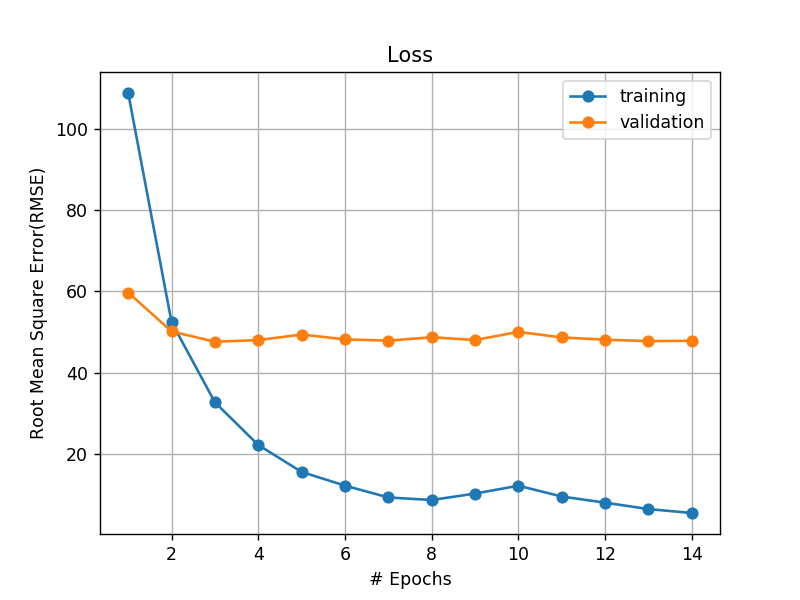

292/292 [==============================] - 1s     
RMSE for Test data = 56.757538643111296


<IPython.core.display.Javascript object>


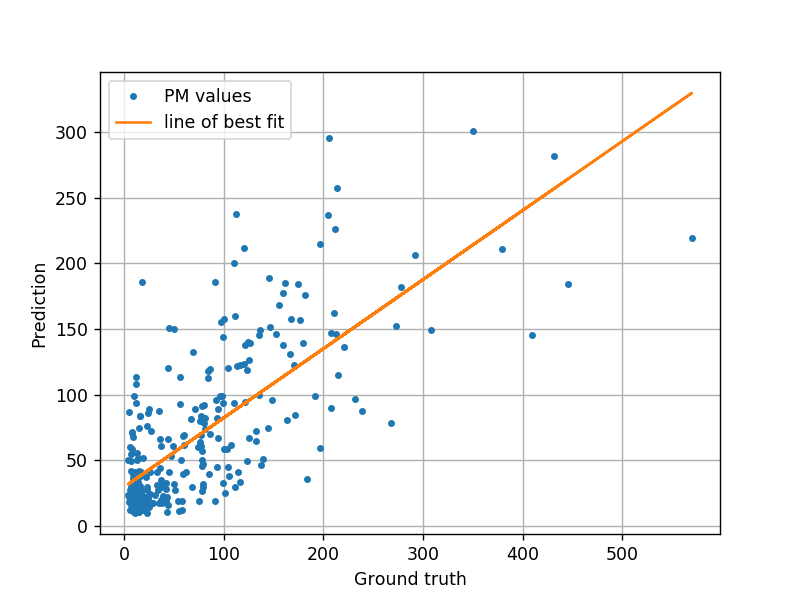

In [13]:
train_cnn(k=1)
evaluate_model(k=1)

## Second fold ( K = 2 )
- Using second set of 20% images for validation and
- Remaining 80% of images for training and validation

Train on 2044 samples, validate on 146 samples


Epoch 1/100
2044/2044 [==============================] - 16s - loss: 15009.2030 - val_loss: 7840.8733


Epoch 2/100
2044/2044 [==============================] - 18s - loss: 2875.6984 - val_loss: 3846.3608


Epoch 3/100
2044/2044 [==============================] - 17s - loss: 978.8554 - val_loss: 3543.1071


Epoch 4/100
2044/2044 [==============================] - 18s - loss: 519.3803 - val_loss: 3163.0571


Epoch 5/100
2044/2044 [==============================] - 9s - loss: 261.1829 - val_loss: 3482.4819


Epoch 6/100
2044/2044 [==============================] - 9s - loss: 163.2617 - val_loss: 3270.2413


Epoch 7/100
2044/2044 [==============================] - 9s - loss: 201.0357 - val_loss: 4074.8714


Epoch 8/100
2044/2044 [==============================] - 9s - loss: 277.4832 - val_loss: 3500.3287


Epoch 9/100
2044/2044 [==============================] - 9s - loss: 180.3866 - val_loss: 3510.9029


Epoch 10/100
2044/2044 [==============================] - 9s - loss: 107.3676 - val_loss: 3467.6706


Epoch 11/100
2044/2044 [==============================] - 9s - loss: 67.2289 - val_loss: 3536.9806


Epoch 12/100
2044/2044 [==============================] - 9s - loss: 38.7389 - val_loss: 3450.8270


Epoch 13/100
2044/2044 [==============================] - 9s - loss: 23.2437 - val_loss: 3430.5485


Epoch 14/100
2044/2044 [==============================] - 9s - loss: 17.3543 - val_loss: 3538.0536


Epoch 15/100
2044/2044 [==============================] - 9s - loss: 16.1854 - val_loss: 3478.5998



<IPython.core.display.Javascript object>


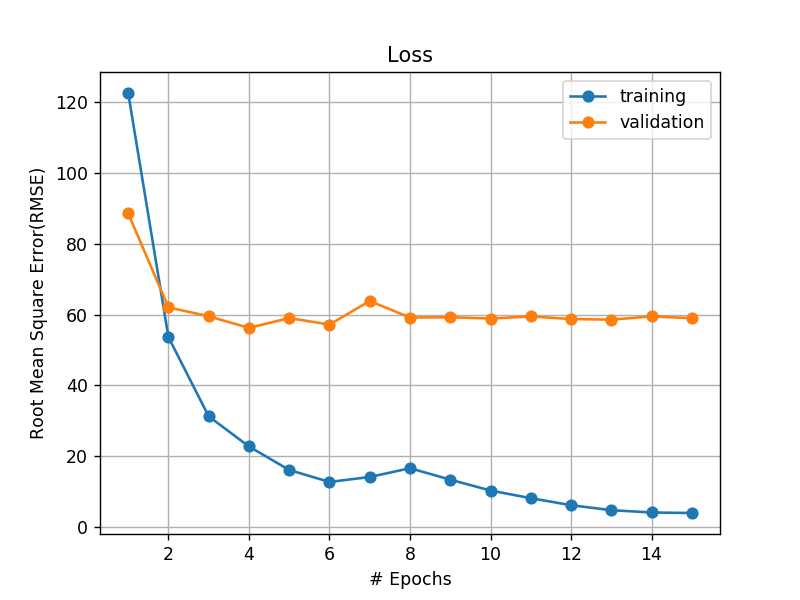

292/292 [==============================] - 1s     
RMSE for Test data = 60.76270903976584


<IPython.core.display.Javascript object>


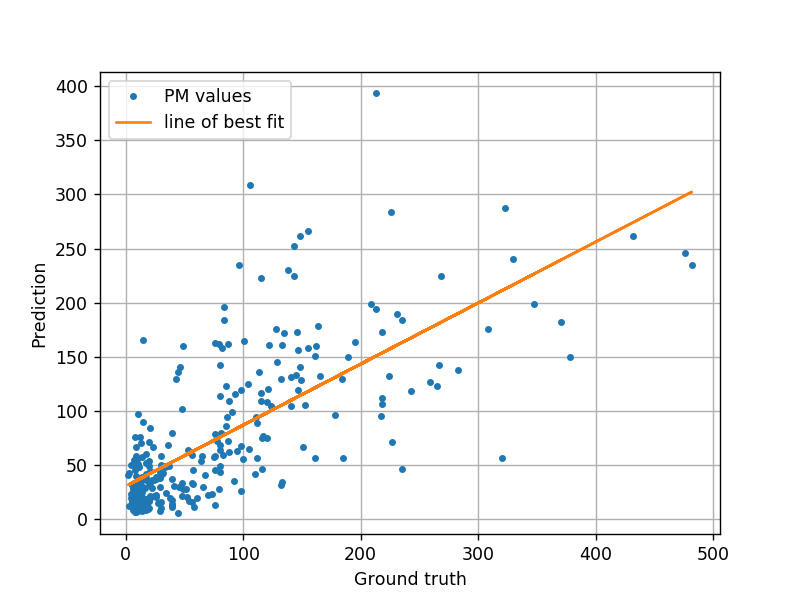

In [6]:
train_cnn(k=2)
evaluate_model(k=2)

## K = 3

Train on 2044 samples, validate on 146 samples


Epoch 1/100
2044/2044 [==============================] - 23s - loss: 14303.8659 - val_loss: 4400.3554


Epoch 2/100
2044/2044 [==============================] - 17s - loss: 2905.9751 - val_loss: 2669.8089


Epoch 3/100
2044/2044 [==============================] - 17s - loss: 1480.3950 - val_loss: 2573.4273


Epoch 4/100
2044/2044 [==============================] - 9s - loss: 727.1024 - val_loss: 2871.5491


Epoch 5/100
2044/2044 [==============================] - 9s - loss: 300.3961 - val_loss: 2625.8847


Epoch 6/100
2044/2044 [==============================] - 9s - loss: 130.1228 - val_loss: 2638.2213


Epoch 7/100
2044/2044 [==============================] - 9s - loss: 85.3288 - val_loss: 2765.2559


Epoch 8/100
2044/2044 [==============================] - 9s - loss: 74.2010 - val_loss: 2652.4602


Epoch 9/100
2044/2044 [==============================] - 17s - loss: 73.9833 - val_loss: 2537.5606


Epoch 10/100
2044/2044 [==============================] - 9s - loss: 89.1784 - val_loss: 2836.0441


Epoch 11/100
2044/2044 [==============================] - 9s - loss: 106.1713 - val_loss: 2604.0639


Epoch 12/100
2044/2044 [==============================] - 17s - loss: 101.1870 - val_loss: 2487.3622


Epoch 13/100
2044/2044 [==============================] - 9s - loss: 108.7046 - val_loss: 2682.6571


Epoch 14/100
2044/2044 [==============================] - 9s - loss: 103.7742 - val_loss: 2702.1382


Epoch 15/100
2044/2044 [==============================] - 9s - loss: 84.6072 - val_loss: 2603.2637


Epoch 16/100
2044/2044 [==============================] - 9s - loss: 84.9571 - val_loss: 2676.2686


Epoch 17/100
2044/2044 [==============================] - 9s - loss: 66.8560 - val_loss: 2532.7274


Epoch 18/100
2044/2044 [==============================] - 9s - loss: 68.9106 - val_loss: 2628.1760


Epoch 19/100
2044/2044 [==============================] - 9s - loss: 67.8600 - val_loss: 2701.2040


Epoch 20/100
2044/2044 [==============================] - 9s - loss: 44.4286 - val_loss: 2668.7594


Epoch 21/100
2044/2044 [==============================] - 9s - loss: 35.3096 - val_loss: 2719.0796


Epoch 22/100
2044/2044 [==============================] - 9s - loss: 24.4993 - val_loss: 2681.0813


Epoch 23/100
2044/2044 [==============================] - 9s - loss: 19.2845 - val_loss: 2565.4512



<IPython.core.display.Javascript object>


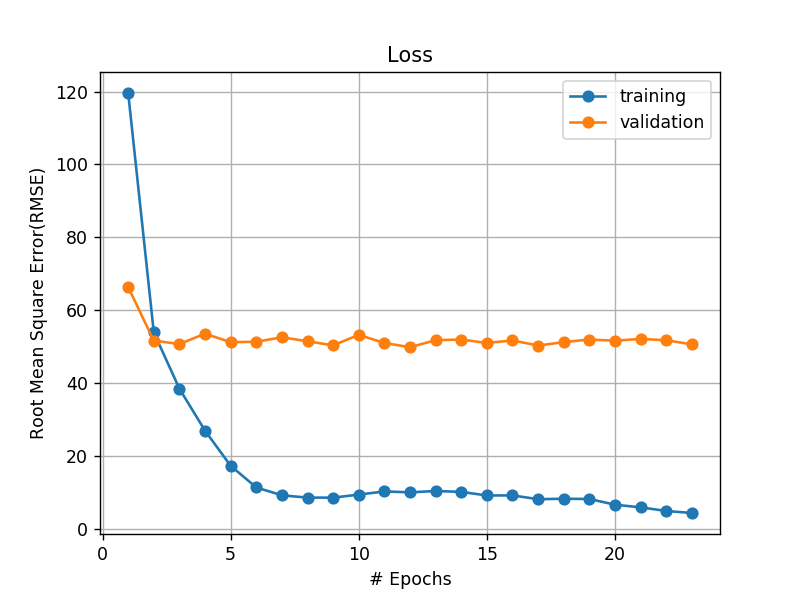

292/292 [==============================] - 1s     
RMSE for Test data = 59.41270522331107


<IPython.core.display.Javascript object>


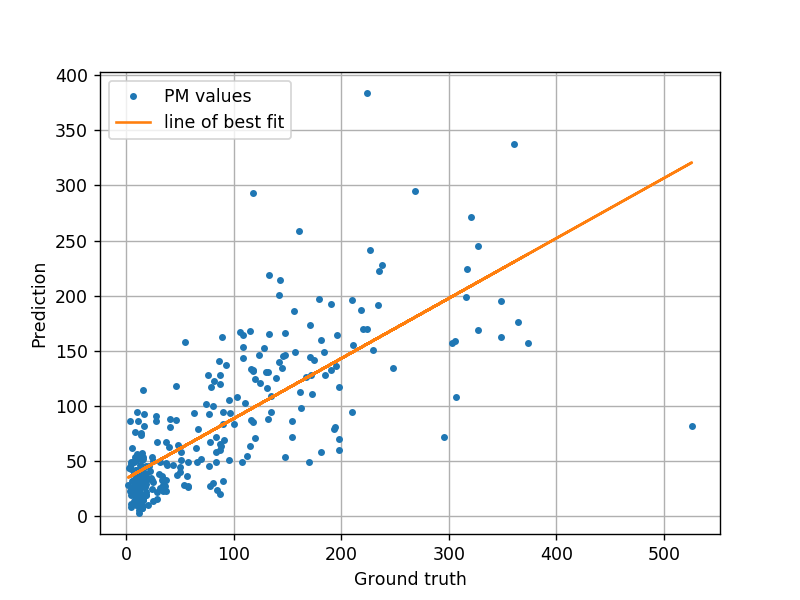

In [6]:
train_cnn(k=3)
evaluate_model(k=3)

## K = 4

Train on 2044 samples, validate on 146 samples


Epoch 1/100
2044/2044 [==============================] - 14s - loss: 15244.1829 - val_loss: 3126.8053


Epoch 2/100
2044/2044 [==============================] - 18s - loss: 2730.7029 - val_loss: 2444.4843


Epoch 3/100
2044/2044 [==============================] - 17s - loss: 1167.6891 - val_loss: 2392.9528


Epoch 4/100
2044/2044 [==============================] - 18s - loss: 562.3994 - val_loss: 2231.4411


Epoch 5/100
2044/2044 [==============================] - 9s - loss: 279.1466 - val_loss: 2328.6697


Epoch 6/100
2044/2044 [==============================] - 17s - loss: 180.9677 - val_loss: 2215.2304


Epoch 7/100
2044/2044 [==============================] - 9s - loss: 115.6649 - val_loss: 2231.2876


Epoch 8/100
2044/2044 [==============================] - 9s - loss: 197.1922 - val_loss: 2365.8069


Epoch 9/100
2044/2044 [==============================] - 9s - loss: 155.3874 - val_loss: 2288.2613


Epoch 10/100
2044/2044 [==============================] - 9s - loss: 121.8226 - val_loss: 2249.8218


Epoch 11/100
2044/2044 [==============================] - 9s - loss: 118.4477 - val_loss: 2331.7524


Epoch 12/100
2044/2044 [==============================] - 9s - loss: 81.8992 - val_loss: 2248.9843


Epoch 13/100
2044/2044 [==============================] - 9s - loss: 48.8200 - val_loss: 2227.7864


Epoch 14/100
2044/2044 [==============================] - 9s - loss: 35.5841 - val_loss: 2329.2082


Epoch 15/100
2044/2044 [==============================] - 9s - loss: 21.8586 - val_loss: 2247.4570


Epoch 16/100
2044/2044 [==============================] - 18s - loss: 20.4020 - val_loss: 2196.7229


Epoch 17/100
2044/2044 [==============================] - 9s - loss: 14.3504 - val_loss: 2234.3902


Epoch 18/100
2044/2044 [==============================] - 9s - loss: 10.5784 - val_loss: 2242.6859


Epoch 19/100
2044/2044 [==============================] - 9s - loss: 9.7255 - val_loss: 2223.1843


Epoch 20/100
2044/2044 [==============================] - 9s - loss: 9.1080 - val_loss: 2237.5327


Epoch 21/100
2044/2044 [==============================] - 9s - loss: 9.7075 - val_loss: 2217.2665


Epoch 22/100
2044/2044 [==============================] - 9s - loss: 14.0813 - val_loss: 2226.6896


Epoch 23/100
2044/2044 [==============================] - 9s - loss: 16.3771 - val_loss: 2213.5990


Epoch 24/100
2044/2044 [==============================] - 9s - loss: 14.5591 - val_loss: 2226.4188


Epoch 25/100
2044/2044 [==============================] - 9s - loss: 15.9496 - val_loss: 2224.2375


Epoch 26/100
2044/2044 [==============================] - 9s - loss: 13.7250 - val_loss: 2226.4873


Epoch 27/100
2044/2044 [==============================] - 9s - loss: 11.0309 - val_loss: 2208.2021



<IPython.core.display.Javascript object>


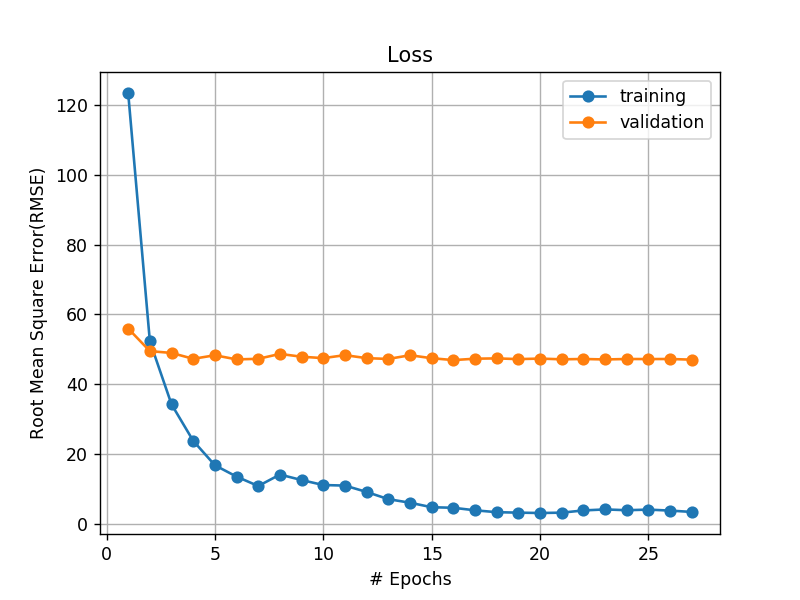

292/292 [==============================] - 1s     
RMSE for Test data = 55.23771260817588


<IPython.core.display.Javascript object>


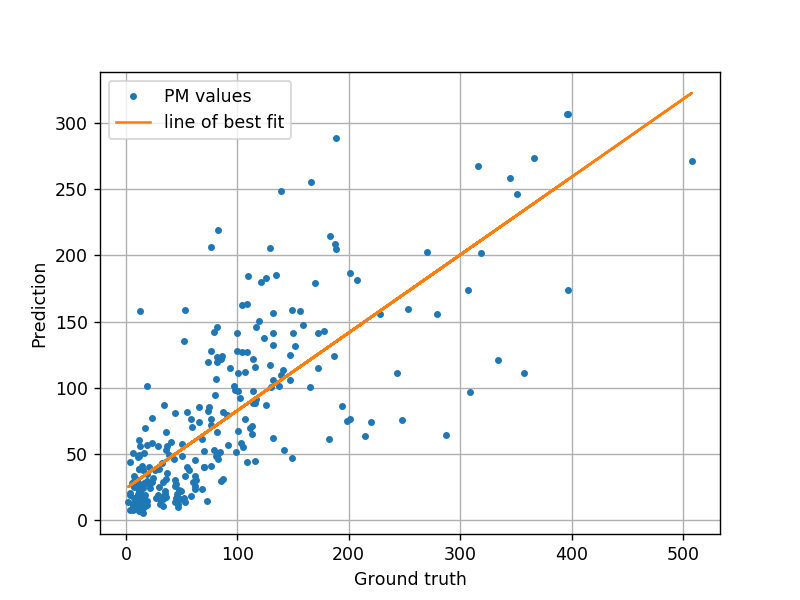

In [6]:
train_cnn(k=4)
evaluate_model(k=4)

## K = 5

Train on 2044 samples, validate on 146 samples


Epoch 1/100
2044/2044 [==============================] - 15s - loss: 14920.3706 - val_loss: 5451.5322


Epoch 2/100
2044/2044 [==============================] - 18s - loss: 2260.1299 - val_loss: 4724.8067


Epoch 3/100
2044/2044 [==============================] - 9s - loss: 768.6648 - val_loss: 4772.0232


Epoch 4/100
2044/2044 [==============================] - 17s - loss: 364.4751 - val_loss: 4713.5124


Epoch 5/100
2044/2044 [==============================] - 9s - loss: 217.4681 - val_loss: 4920.6376


Epoch 6/100
2044/2044 [==============================] - 17s - loss: 160.6463 - val_loss: 4682.7456


Epoch 7/100
2044/2044 [==============================] - 9s - loss: 180.8612 - val_loss: 4861.5421


Epoch 8/100
2044/2044 [==============================] - 9s - loss: 177.4070 - val_loss: 4968.7895


Epoch 9/100
2044/2044 [==============================] - 9s - loss: 125.8598 - val_loss: 5060.9943


Epoch 10/100
2044/2044 [==============================] - 9s - loss: 104.0613 - val_loss: 4822.4384


Epoch 11/100
2044/2044 [==============================] - 9s - loss: 124.9941 - val_loss: 4905.6400


Epoch 12/100
2044/2044 [==============================] - 9s - loss: 114.8255 - val_loss: 4871.8647


Epoch 13/100
2044/2044 [==============================] - 9s - loss: 73.0893 - val_loss: 4891.8455


Epoch 14/100
2044/2044 [==============================] - 9s - loss: 34.6748 - val_loss: 4945.4442


Epoch 15/100
2044/2044 [==============================] - 9s - loss: 20.9195 - val_loss: 4837.1698


Epoch 16/100
2044/2044 [==============================] - 9s - loss: 13.1287 - val_loss: 4854.8780


Epoch 17/100
2044/2044 [==============================] - 9s - loss: 11.1623 - val_loss: 4887.3075



<IPython.core.display.Javascript object>


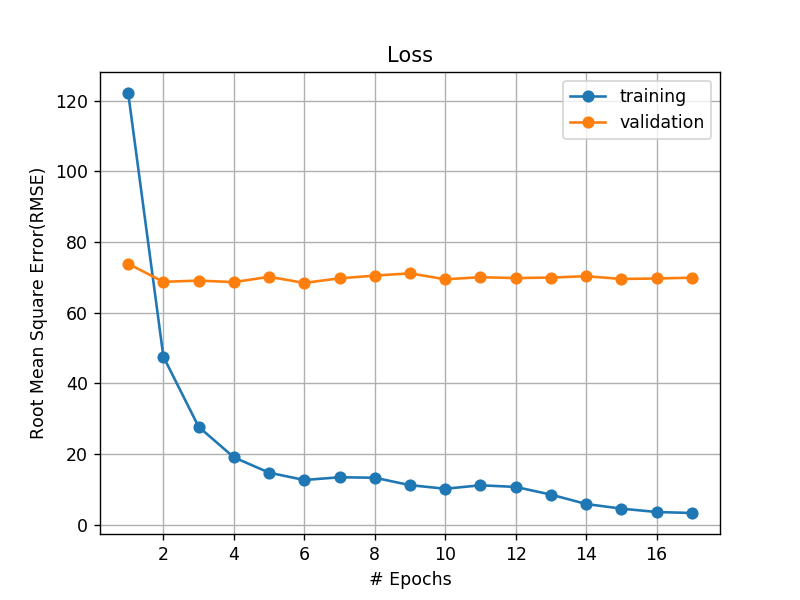

292/292 [==============================] - 1s     
RMSE for Test data = 63.87422422721242


<IPython.core.display.Javascript object>


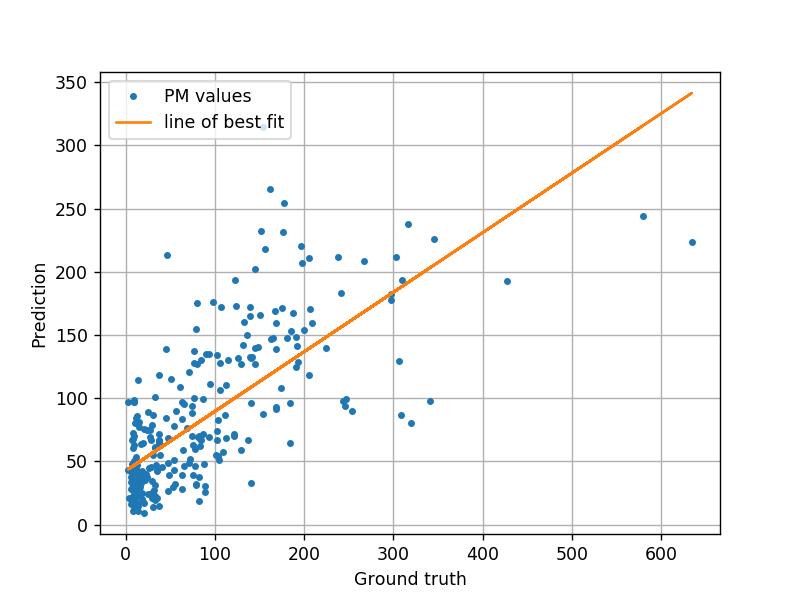

In [6]:
train_cnn(k=5)
evaluate_model(k=5)

## Combination of 5 models

<IPython.core.display.Javascript object>


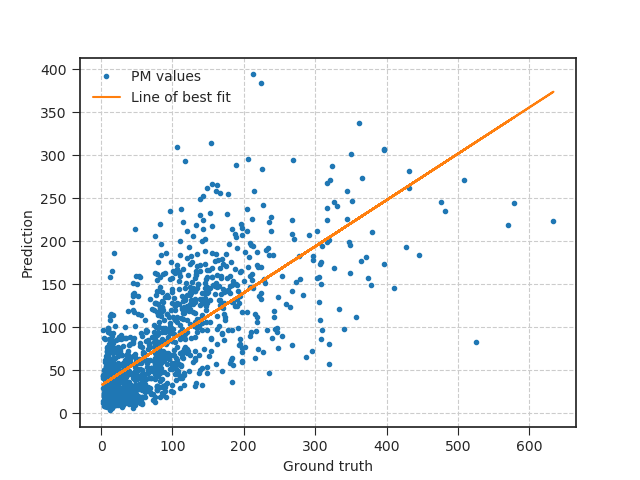

In [28]:
x=[]
y=[]
z=[]
for i in range(5):
    eval_data=np.load('eval/eval_data{}.npz'.format(i+1))
    for m in range(len(eval_data['x'])):
                   x.append(eval_data['x'][m])
                   y.append(eval_data['y'][m])
                   z.append(eval_data['z'][m])

x=np.array(x)
y=np.array(y)
y[y<0]=0
z=np.array(z)

m, b = np.polyfit(x, y, 1)
plt.figure()
plt.plot(x, y, '.', label="PM values")
plt.plot(x, m*x + b, '-', label="Line of best fit")
plt.legend(loc='upper left')
plt.ylabel('Prediction')
plt.xlabel('Ground truth')
plt.grid(linestyle="--")
plt.show()

In [30]:
result = open('result.csv', 'w')
result.write('Image_Name,Original_PM,Predicted_PM\n')
for i in range(len(x)):
        result.write('{},{},{:.2f}\n'.format(z[i], x[i], y[i]))
result.close()

## RMS error 

In [31]:
rmse=np.sqrt(np.mean(np.square(x-y)))
print("RMS Error = {:.3f}".format(rmse))

RMS Error = 59.287


## R squared

In [32]:
SSE=np.sum(np.square(x-y))
SST=np.sum(np.square(x - np.mean(x)))

r_squared = 1-(SSE/SST)
print("R squared  = {:.3f}".format(r_squared))

R squared  = 0.545


In [33]:
res=pd.read_csv('result.csv')
display(res.head())
print(res['Predicted_PM'].describe())

,Image_Name,Original_PM,Predicted_PM
0,images/The-2nd-ring-roadBeijing6-1510-09092013-78.jpg,78.0,91.06
1,images/Dawang-road-Beijing11-12.01-05222016.jpg,58.0,18.74
2,images/Baiziwan-Beijing-11.11-11022016.jpg,93.0,44.95
3,images/Liangmaqiao-Beijing4-08.28-01282016.jpg,126.0,139.26
4,images/Chongwenmen-Beijing12-15.39-03122016.jpg,113.0,121.83


count    1460.000000
mean     74.875014  
std      63.991674  
min      3.110000   
25%      25.565000  
50%      51.375000  
75%      111.370000 
max      393.810000 
Name: Predicted_PM, dtype: float64


<IPython.core.display.Javascript object>


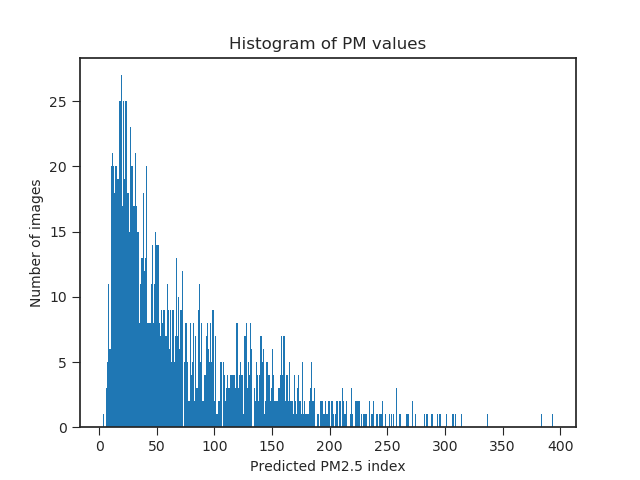

In [34]:
plt.figure()
preds=res['Predicted_PM'].round().astype(int)
plt.hist(preds, bins=max(preds))
plt.xlabel('Predicted PM2.5 index')
plt.ylabel('Number of images')
plt.title('Histogram of PM values')
plt.show()

## Joint plot

<IPython.core.display.Javascript object>


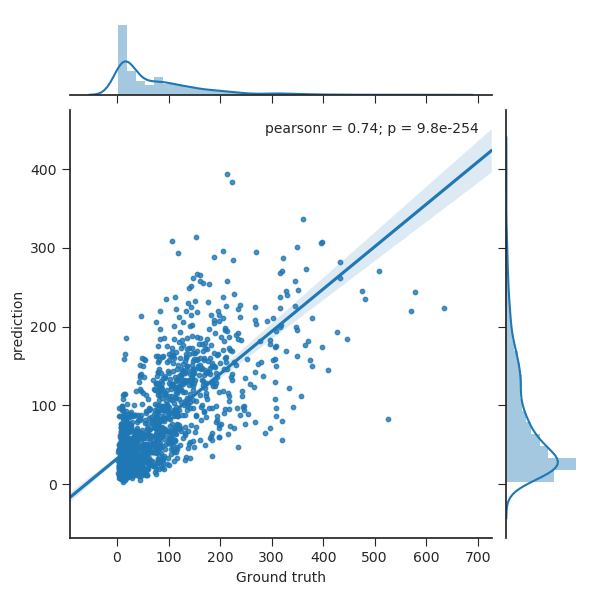

In [35]:
sns.jointplot(data=res, x='Original_PM', y='Predicted_PM', kind='reg', scatter_kws={"s": 10}).set_axis_labels("Ground truth", "prediction")

## Distribution of residuals

<IPython.core.display.Javascript object>


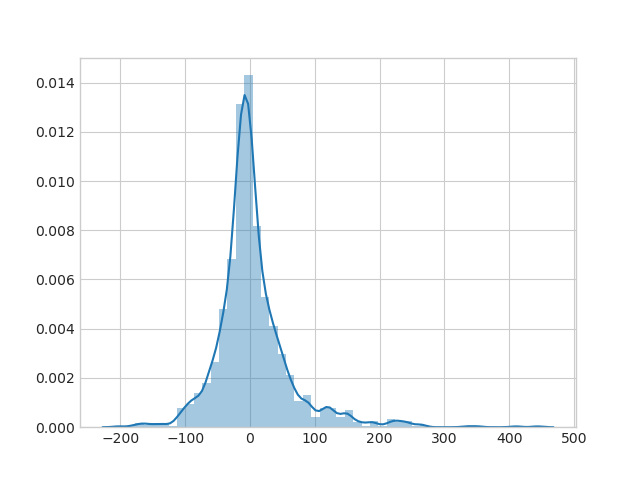

In [26]:
plt.figure()
sns.distplot(res['Original_PM']-res['Predicted_PM'])
plt.show()

## Some Incorrect  Predictions

<IPython.core.display.Javascript object>


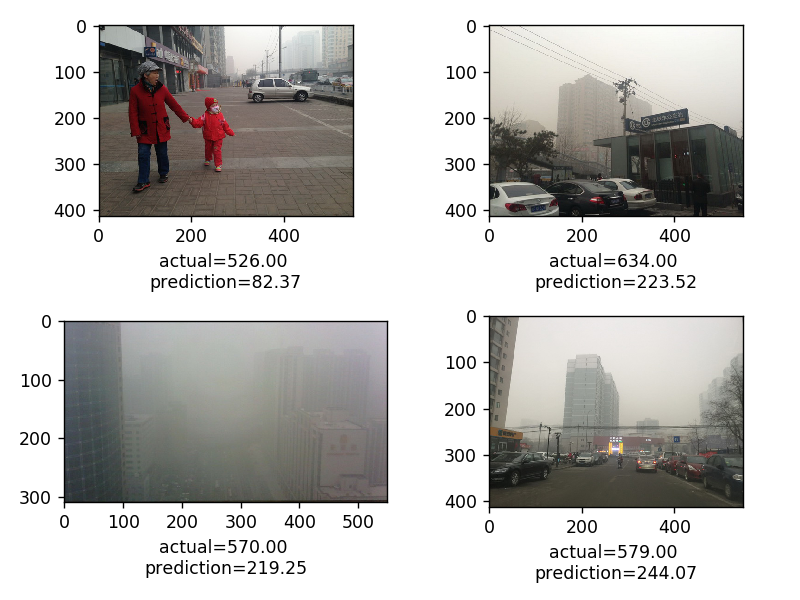

In [13]:
top_5_index=(res['Original_PM'] - res['Predicted_PM']).abs().nlargest(5).index.values
n=4
#plt.figure(figsize=(12,10))
plt.figure()

for i in range(n):
    plt.subplot(math.ceil(n/2),2,i+1)
    plt.imshow(Image.open("../{}".format(z[top_5_index[i]])))
    plt.xlabel('actual={:0.2f} \nprediction={:0.2f}'.format(x[top_5_index[i]], y[top_5_index[i]]))

plt.tight_layout()
plt.show()


## Some correct predictions

<IPython.core.display.Javascript object>


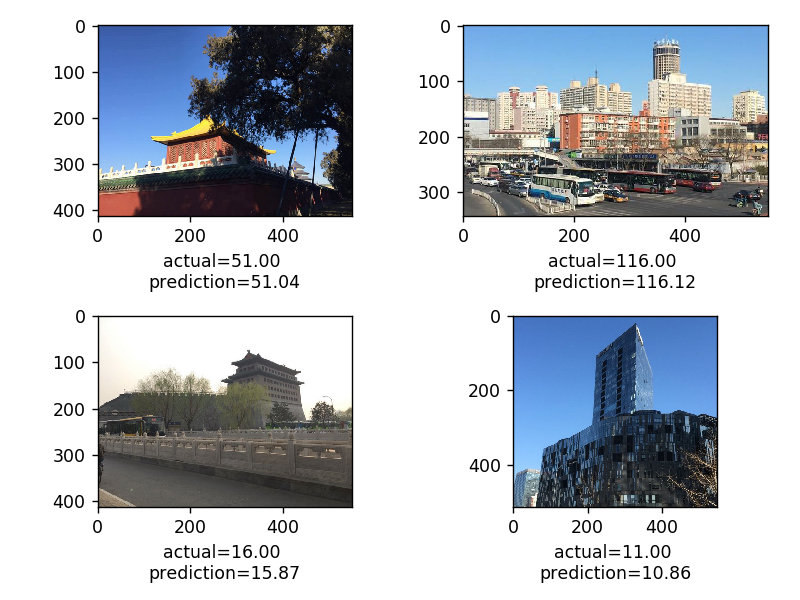

In [14]:
top_5_index=(res['Original_PM'] - res['Predicted_PM']).abs().nsmallest(25).index.values
#plt.figure(figsize=(12,10))
plt.figure()
for i in range(4):
    plt.subplot(math.ceil(n/2),2,i+1)
    plt.imshow(Image.open("../{}".format(z[top_5_index[i]])))
    plt.xlabel('actual={:0.2f} \nprediction={:0.2f}'.format(x[top_5_index[i+1]], y[top_5_index[i+1]])) 
plt.tight_layout()
plt.show()

In [ ]:
top_5_index=(res['Original_PM'] - res['Predicted_PM']).abs().nsmallest(3770).index.values

copy_script=open("copy_script", "w")

for i in range(3770):
    img_name=z[top_5_index[i]]
    real_PM=x[top_5_index[i]]
    predicted_PM=y[top_5_index[i]]
    dest_path='/home/cvpr/Desktop/imgs/img{:04}_Real_{:.2f}_Predicted_{:.2f}.jpg'.format(i+1, real_PM, predicted_PM)
    syntax='cp {} {}\n'.format(img_name, dest_path)
    copy_script.write(syntax)

copy_script.close()
#plt.figure()
#plt.imshow(Image.open(z[top_5_index[i]]))